# Solar prediction

In [1]:
import xarray as xr
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import cartopy.crs as ccrs
import cartopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler
from temp_clustering import cluster_temp_diff
from sklearn.model_selection import train_test_split
from Smoothed_Values import Smoothed_Temp_Solar

import ipywidgets as widgets
from ipywidgets import interact
from settings import path_data

In [2]:
def smooth_butter(data, order):
    b, a = signal.butter(order, 0.125)
    y = signal.filtfilt(b, a, data)#, padlen=150)
    return y

In [3]:
ds_solar = xr.open_dataset(path_data / 'Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset(path_data / 'Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset(path_data / 'T2m_R1_ym_1stMill.nc')
ds_temp_r2 = xr.open_dataset(path_data / 'T2m_R2_ym_1stMill.nc')

In [5]:
# Dataset for Solar Forcing
df_solar = {'time':ds_solar.time.values, 'TSI':ds_solar.TSI.values.flatten()}

# Dataset for volcanic forcing
df_volc = {'time':ds_volc.time.values, 'AOD':ds_volc.AOD.values.flatten()}

# Dataset for R1
df_R2 = {'time': ds_temp_r1.time.values, 'lon':ds_temp_r1.lon.values, 'lat': ds_temp_r1.lat.values, 'T2m':ds_temp_r1.T2m.values}

# Dataset for R2
df_R1 = {'time': ds_temp_r2.time.values, 'lon':ds_temp_r2.lon.values, 'lat': ds_temp_r2.lat.values, 'T2m':ds_temp_r2.T2m.values}

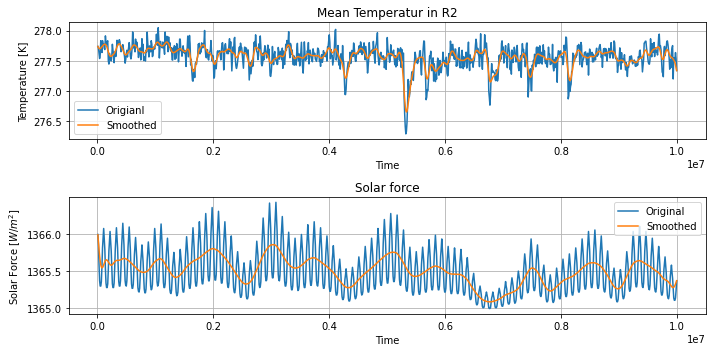

In [7]:
clust = 8
fig, ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(df_R1['time'], np.mean(np.mean(df_R1['T2m'], axis = 1),1), label = 'Origianl')
ax[0].plot(df_R1['time'], smooth_butter(np.mean(np.mean(df_R1['T2m'], axis = 1),1),2), label = 'Smoothed')
ax[0].set_title('Mean Temperatur in R2')
ax[0].set_ylabel('Temperature [K]')

ax[1].plot(df_solar['time'], df_solar['TSI'], label = 'Original')
ax[1].plot(df_solar['time'], smooth_butter(df_solar['TSI'],clust), label = 'Smoothed')
ax[1].set_title('Solar force')
ax[1].set_ylabel(r'Solar Force $[W/m^2]$')

for a in ax:
    a.grid()
    a.legend();
    a.set_xlabel('Time')
fig.tight_layout()

In [8]:
def get_pears(Temperature, Solar):

    pears_coeff_smooth = np.zeros(shape = (Temperature.shape[1], Temperature.shape[2]))
    pears_coeff = np.zeros(shape = (Temperature.shape[1], Temperature.shape[2]))
    pears_coeff_doubleSmooth = np.zeros(shape = (Temperature.shape[1], Temperature.shape[2]))


    smooth_solar = smooth_butter(Solar,8)
    for i in range(Temperature.shape[1]):
        for j in range(Temperature.shape[2]):
            pears_coeff_smooth[i,j] = stats.pearsonr(Temperature[:,i,j], smooth_solar)[0]
            pears_coeff[i,j] = stats.pearsonr(Temperature[:,i,j], Solar)[0]
            pears_coeff_doubleSmooth[i,j] = stats.pearsonr(smooth_butter(Temperature[:,i,j],8), smooth_solar)[0]
    return pears_coeff, pears_coeff_smooth, pears_coeff_doubleSmooth

In [9]:
###############
## Split the dataset and return the pearson coefficient maps
x_train1, x_test1, y_train1, y_test1 = train_test_split(df_R1['T2m'], df_solar['TSI'], test_size=0.3, random_state=42,
                                                       shuffle = False)
pears_coeff_train, pears_coeff_smooth_train, pears_coeff_doubleSmooth_train = get_pears(x_train1, y_train1)
pears_coeff_test, pears_coeff_smooth_test, pears_coeff_doubleSmooth_test = get_pears(x_test1, y_test1)
pears_coeff_full, pears_coeff_smooth_full, pears_coeff_doubleSmooth_full = get_pears(df_R1['T2m'], df_solar['TSI'])
#pears_coeff, pears_coeff_smooth, pears_coeff_doubleSmooth = get_pears(df_R1['T2m'], df_solar['TSI'])

In [10]:
def Visualize_pears_coeff(pears_coeff, pears_coeff_smooth, pears_coeff_doubleSmooth):
    lats = df_R1['lat'][:]
    lons = df_R1['lon'][:]
    smooth_solar = smooth_butter(df_solar['TSI'],8)

    f = plt.figure(figsize=(15,12))
    #######################################################
    ## Pearson no smooth
    ax = f.add_subplot(321, projection=ccrs.PlateCarree())
    pos1 = ax.contourf(lons, lats,pears_coeff,transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title('Pearson No smooth - Max R = {:.4f}'.format(np.max(pears_coeff.flatten())))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Lattitude')

    ax1 = f.add_subplot(322)
    ax1.plot(df_R1['T2m'].reshape(-1, 96*192)[:,np.argmax(pears_coeff.flatten())], df_solar['TSI'], 'or')
    ax1.axis('equal')
    ax1.grid()
    ax1.set_title('Pearson No smooth - Max Correlation value')
    ax1.set_xlabel('Temperature [K]')
    ax1.set_ylabel(r'Solar Force $[W/m^2]$')

    #######################################################
    ## Pearson SOlar Smoothed
    ax3 = f.add_subplot(323, projection=ccrs.PlateCarree())
    pos2 = ax3.contourf(lons, lats, pears_coeff_smooth,transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
    ax3.coastlines()
    ax3.set_title('Pearson Solar smoothed - Max R = {:.4f}'.format(np.max(pears_coeff_smooth.flatten())))
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Lattitude')

    ax4 = f.add_subplot(324)
    ax4.plot(df_R1['T2m'].reshape(-1, 96*192)[:,np.argmax(pears_coeff_smooth.flatten())], smooth_solar, 'or')
    ax4.axis('equal')
    ax4.grid()
    ax4.set_title('Pearson Solar smoothed - Max Correlation value')
    ax4.set_xlabel('Temperature [K]')
    ax4.set_ylabel(r'Solar Force $[W/m^2]$')

    #######################################################
    ## Pearson SOlar and Temperature Smoothed
    ax5 = f.add_subplot(325, projection=ccrs.PlateCarree())
    pos3 = ax5.contourf(lons, lats,pears_coeff_doubleSmooth,transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
    ax5.coastlines()
    ax5.set_title('Pearson Solar & Temperature smoothed - Max R = {:.4f}'.format(np.max(pears_coeff_doubleSmooth.flatten())))
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Lattitude')

    ax6 = f.add_subplot(326)
    ax6.plot(df_R1['T2m'].reshape(-1, 96*192)[:,np.argmax(pears_coeff_doubleSmooth.flatten())], smooth_solar, 'or')
    ax6.axis('equal')
    ax6.grid()
    ax6.set_title('Pearson Solar & Temperature smoothed - Max Correlation value')
    ax6.set_xlabel('Temperature [K]')
    ax6.set_ylabel(r'Solar Force $[W/m^2]$')


    f.colorbar(pos1, ax = ax)
    f.colorbar(pos2, ax = ax3)
    f.colorbar(pos3, ax = ax5)
    f.tight_layout();

c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


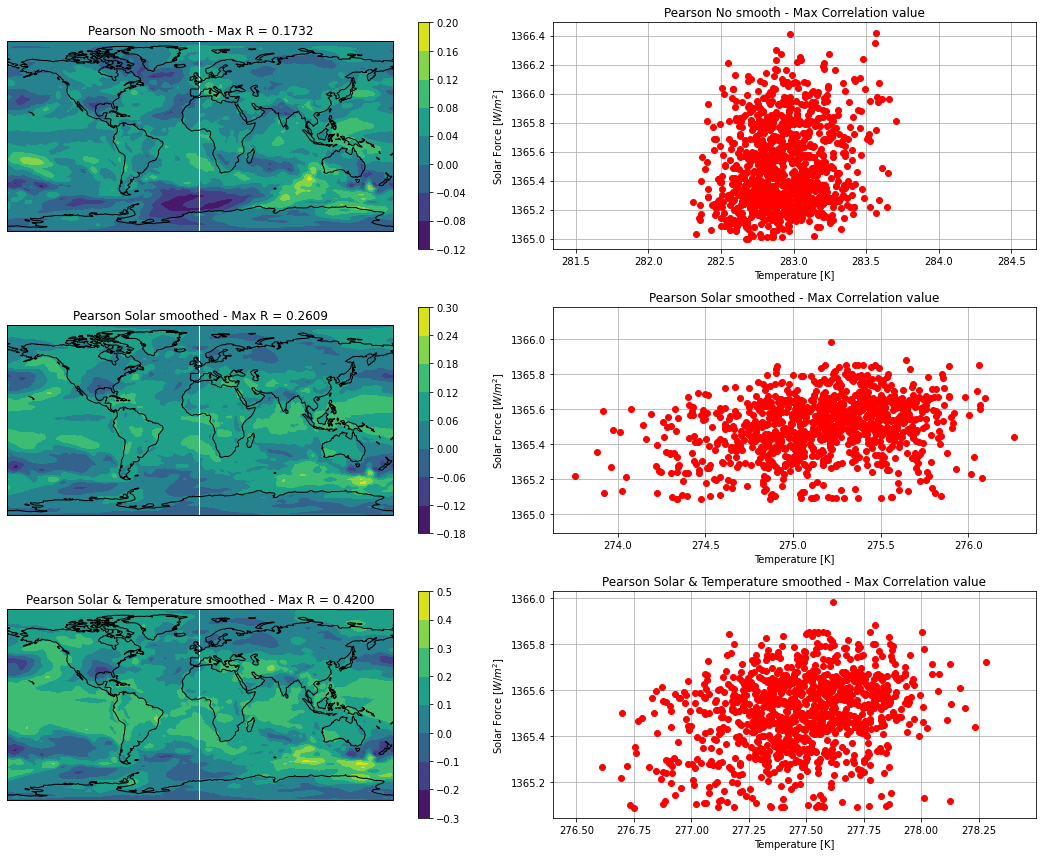

In [11]:
Visualize_pears_coeff(pears_coeff_full, pears_coeff_smooth_full, pears_coeff_doubleSmooth_full)

c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


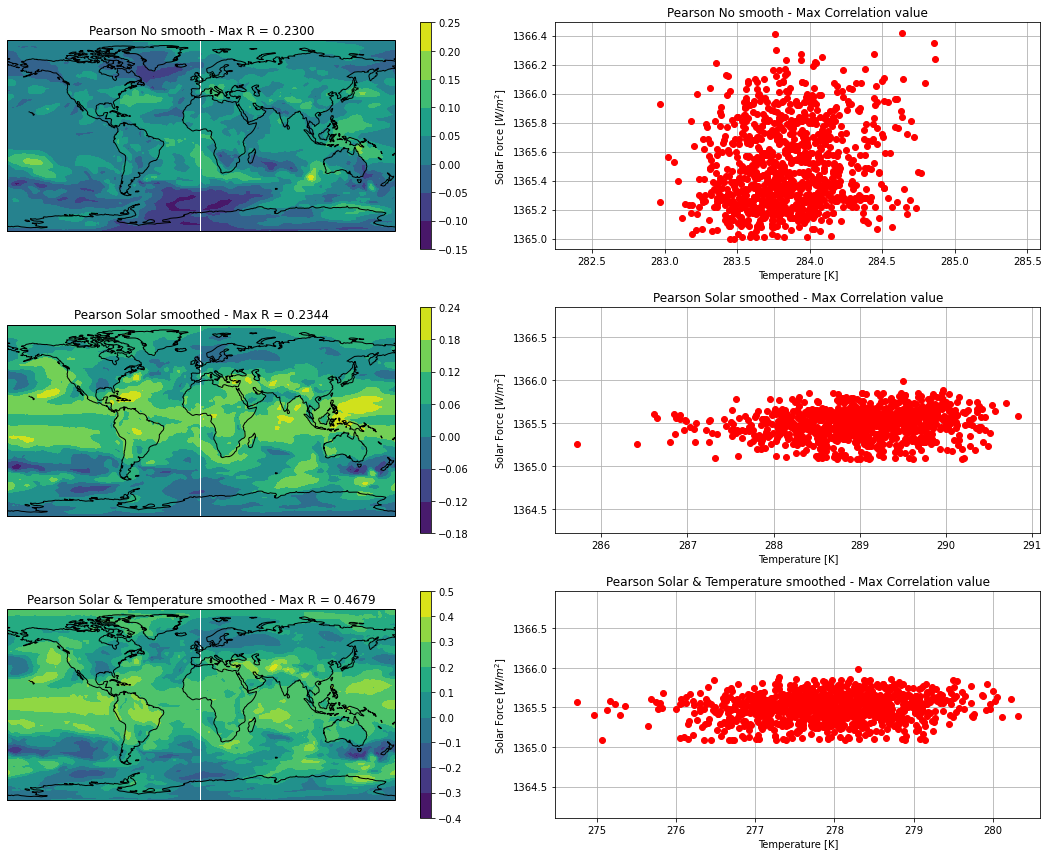

In [12]:
Visualize_pears_coeff(pears_coeff_train, pears_coeff_smooth_train, pears_coeff_doubleSmooth_train)

c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
c:\users\heiko\anaconda3\envs\tf_cpu\lib\site-packages\cartopy\mpl\geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'projection'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


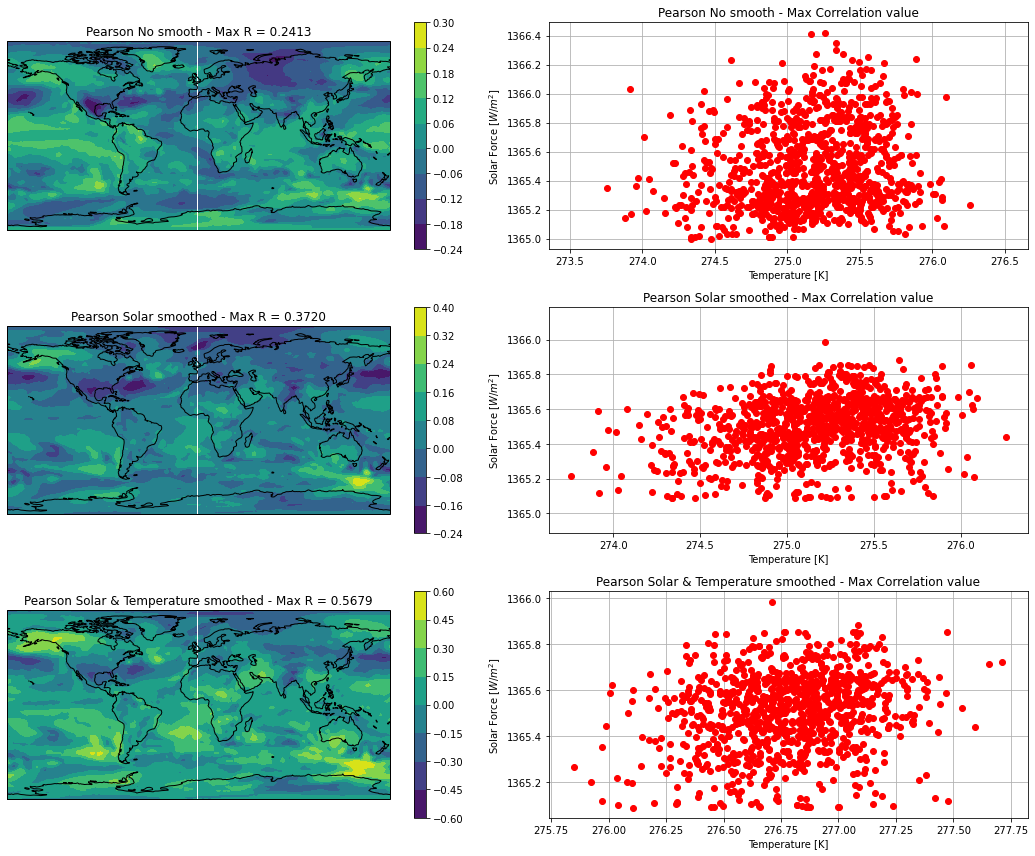

In [13]:
Visualize_pears_coeff(pears_coeff_test, pears_coeff_smooth_test, pears_coeff_doubleSmooth_test)

In [16]:
def visualize_temperature_over_time(Temperature, Pearson_coeff_map):
    boarder = np.max(Pearson_coeff_map.flatten()) - np.max(Pearson_coeff_map.flatten())*.1
    y_val = Temperature[:,Pearson_coeff_map>boarder]
    
    Nb_TimeSeries = y_val.shape[1]
    fig,ax = plt.subplots(Nb_TimeSeries, 1, figsize = (10,6))
    for i in range(0, Nb_TimeSeries):
        ax[i].plot(y_val[:,i])

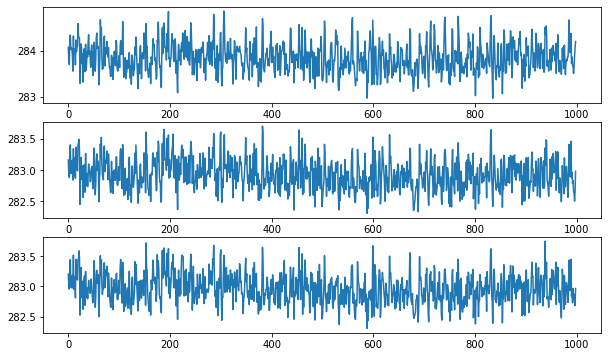

In [17]:
visualize_temperature_over_time(df_R1['T2m'], pears_coeff_full)

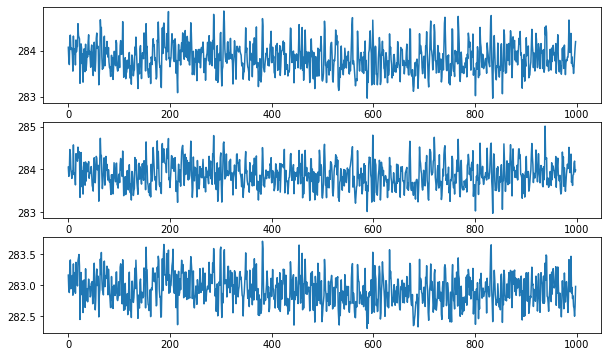

In [18]:
visualize_temperature_over_time(df_R1['T2m'], pears_coeff_train)

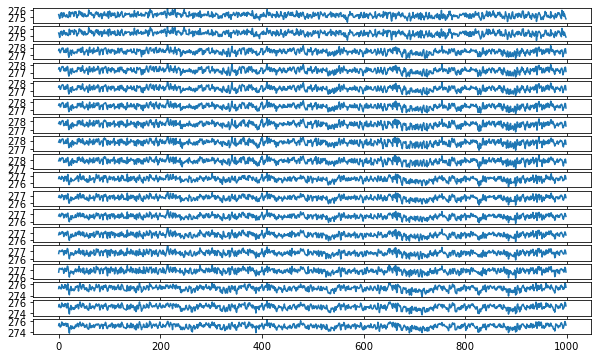

In [19]:
visualize_temperature_over_time(df_R1['T2m'], pears_coeff_test)

In [34]:
def Visualize_Mean_Temp(year_idx):
    
    Temperature=df_R1['T2m'][df_volc['AOD'] > 0]

    lats = df_R1['lat'][:]
    lons = df_R1['lon'][:]
    
    Mean_Temp = np.mean(Temperature,axis = 0)

    f = plt.figure(figsize=(14,10))
    #######################################################
    ## Pearson no smooth
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())
    pos1 = ax.contourf(lons, lats, Mean_Temp, transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title('Mean Temperature between {} to {} years'
                 .format(year_idx, year_idx+100))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Lattitude')
    f.colorbar(pos1, ax = ax)
    
year_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=900,
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [35]:
interact(Visualize_Mean_Temp, year_idx = year_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Year:', max=900), Output()), _d…

<function __main__.Visualize_Mean_Temp(year_idx)>

In [44]:
df_R1['T2m'].shape

(999, 96, 192)

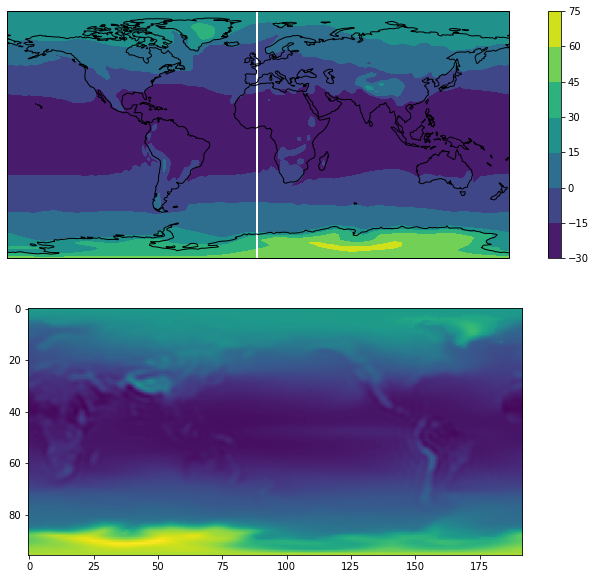

In [48]:
Temperature=df_R1['T2m'][np.argmax(df_volc['AOD'])]

lats = df_R1['lat'][:]
lons = df_R1['lon'][:]

#Mean_Temp = np.mean(Temperature,axis = 0)
Mean_Temp2 = np.mean(df_R1['T2m'][df_volc['AOD'] > 0]) - np.mean(df_R1['T2m'][df_volc['AOD'] == 0],0)

f = plt.figure(figsize=(14,10))
#######################################################
## Pearson no smooth
ax = f.add_subplot(211, projection=ccrs.PlateCarree())
pos1 = ax.contourf(lons, lats, Mean_Temp2, transform=ccrs.PlateCarree(),projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('')
ax.set_xlabel('Longitude')
ax.set_ylabel('Lattitude')
f.colorbar(pos1, ax = ax)

ax2 = f.add_subplot(212)
ax2.imshow(Mean_Temp2)

## Tensorflow Model

In [103]:
def reshape_data_window_approach(df, output, window_size, 
                                 step_size):

    labels = []
    data = []
    
    final_idx = df.shape[0] - window_size
    for i in range(0, df.shape[0], step_size):
        if i+window_size <= df.shape[0]:
            idx = range(i,i+window_size)
            
            #data.append(np.transpose(df[idx,:], (1,0)))
            data.append(df[idx,:])
            labels.append(np.reshape(output[idx],(window_size)))
    return np.array(data), np.array(labels)

def split_dataset(x, y, split_start, split_end):
    x_test = x[split_start:split_end]
    y_test = y[split_start:split_end]
    
    x_train = np.append(x[:split_start], x[split_end:], axis = 0)
    y_train = np.append(y[:split_start], y[split_end:], axis = 0)
    return x_train, x_test, y_train, y_test

def get_preprocessed_data(df_train, df_train_y, pears_coeff_map, time_enroll, step_size, k, test_size):
    # Find most correlated data between Solar Force and Temperature Model
    boarder = np.max(pears_coeff_map.flatten()) - np.max(pears_coeff_map.flatten())*.1
    df_R1_train = df_train[:,pears_coeff_map>boarder]
    # Split dataset
    x_data, x_validation, y_data, y_validation = split_dataset(df_R1_train, df_train_y, k*test_size, (k+1)*test_size)
    # Windowing dataset
    x_train, y_train = reshape_data_window_approach(x_data, y_data, time_enroll, step_size)
    x_val, y_val = reshape_data_window_approach(x_validation, y_validation, time_enroll, step_size)
        
    return x_train, x_val, x_val, y_val

In [129]:
# with test_size = 200 -> max k = 4 -> 5 K-fold CV
x_train, x_test, y_train, y_test = get_preprocessed_data(df_R1['T2m'], 
                                                         smooth_butter(df_solar['TSI'],8), 
                                                         pears_coeff_doubleSmooth_full,
                                                         time_enroll = 100, step_size = 1, k=4, test_size = 200)

print("x_train      = {}".format(x_train.shape))
print("y_train      = {}".format(y_train.shape))
print("x_test       = {}".format(x_test.shape))
print("y_test       = {}".format(y_test.shape))

x_train      = (701, 100, 16)
y_train      = (701, 100)
x_test       = (100, 100, 16)
y_test       = (100, 100)


In [130]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

#scaler_y = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_test_scaled = scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

In [131]:
y_train_scaled.shape

(701, 100)

In [132]:
act = 'elu'#'elu'# tanh
model = models.Sequential()
model.add(layers.Conv1D(16, (3), activation= act, input_shape=x_train_scaled.shape[1:], name = 'Inp'))
#model.add(layers.MaxPooling1D((2)))
model.add(layers.Conv1D(32, (3), activation= act, name = 'C1'))
#model.add(layers.MaxPooling1D((2)))
model.add(layers.Conv1D(16, (3), activation= act, name = 'C2'))
model.add(layers.MaxPooling1D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation= 'tanh', name = 'D1'))
model.add(layers.Dense(y_train_scaled.shape[-1],activation = 'linear', name = 'Out'))



model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inp (Conv1D)                 (None, 98, 16)            784       
_________________________________________________________________
C1 (Conv1D)                  (None, 96, 32)            1568      
_________________________________________________________________
C2 (Conv1D)                  (None, 94, 16)            1552      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 47, 16)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 752)               0         
_________________________________________________________________
D1 (Dense)                   (None, 256)               192768    
_________________________________________________________________
Out (Dense)                  (None, 100)              

In [133]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
history = model.fit(x_train_scaled, y_train_scaled, epochs=30, shuffle = True, batch_size = 16,
                    validation_data=(x_test_scaled, y_test_scaled))

Train on 701 samples, validate on 100 samples
Epoch 1/30
701/701 [==============================] - 2s 2ms/sample - loss: 0.7013 - val_loss: 0.6436
Epoch 2/30
701/701 [==============================] - 1s 897us/sample - loss: 0.4970 - val_loss: 0.7267
Epoch 3/30
701/701 [==============================] - 1s 913us/sample - loss: 0.3044 - val_loss: 0.7574
Epoch 4/30
701/701 [==============================] - 0s 699us/sample - loss: 0.2100 - val_loss: 0.7530
Epoch 5/30
701/701 [==============================] - 1s 950us/sample - loss: 0.1552 - val_loss: 0.7419
Epoch 6/30
701/701 [==============================] - 1s 736us/sample - loss: 0.1267 - val_loss: 0.7425
Epoch 7/30
701/701 [==============================] - 1s 976us/sample - loss: 0.1152 - val_loss: 0.7382
Epoch 8/30
701/701 [==============================] - 1s 884us/sample - loss: 0.1019 - val_loss: 0.7163
Epoch 9/30
701/701 [==============================] - 1s 1ms/sample - loss: 0.0975 - val_loss: 0.7327
Epoch 10/30
701/701 [=

In [36]:
preds = model.predict(x_test_scaled)
y_rescale_pred = scaler.inverse_transform(preds)

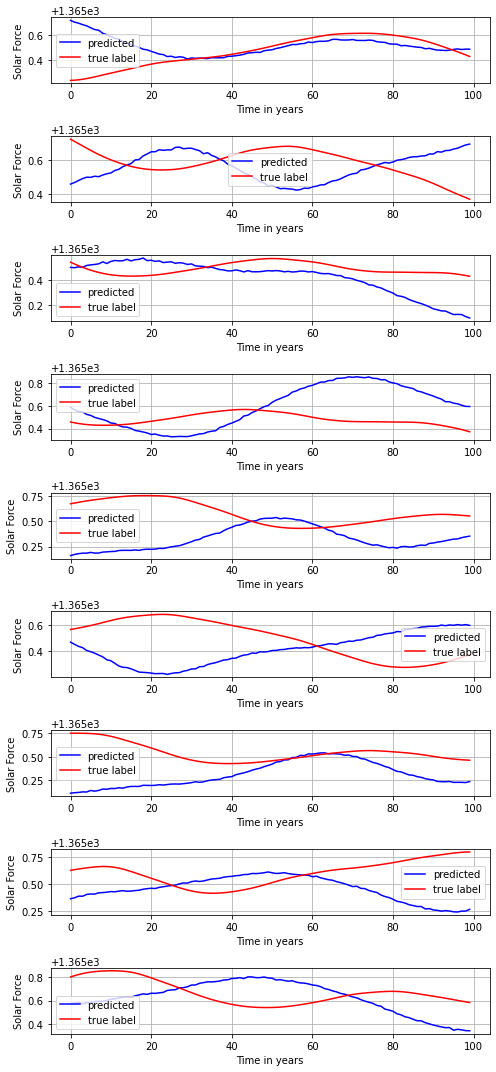

In [38]:
fig, ax = plt.subplots(9,1, figsize=(7,15))
for i, idx in enumerate(range(20,110,10)):
    ax[i].plot(y_rescale_pred[idx],'b',label='predicted')
    ax[i].plot(y_train[idx],'r', label ='true label')
    ax[i].legend()
    ax[i].set_ylabel('Solar Force')
    ax[i].set_xlabel('Time in years')
    ax[i].grid()
    #ax[i].plot(preds[idx]);
fig.tight_layout()